## Transfer learning

In [3]:
import os
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = 'inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)
for layer in pre_trained_model.layers:
               layer.trainable = False
    

In [4]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 74, 74, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 74, 74, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 74, 74, 32)   0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [5]:
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


## Model

In [6]:
from tensorflow.keras.optimizers import RMSprop


x = layers.Flatten()(last_output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)                  
x = layers.Dense(1, activation='sigmoid')(x)           

model = Model(pre_trained_model.input, x) 
# Model(input layer, output layer) 

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['acc'])


More details for tf.keras.Model: https://www.tensorflow.org/api_docs/python/tf/keras/Model

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
base_dir = 'cats_and_dogs_filtered'

train_dir = os.path.join( base_dir, 'train')
validation_dir = os.path.join( base_dir, 'validation')


train_cats_dir = os.path.join(train_dir, 'cats') # Directory with our training cat pictures
train_dogs_dir = os.path.join(train_dir, 'dogs') # Directory with our training dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats') # Directory with our validation cat pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')# Directory with our validation dog pictures

train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator( rescale = 1.0/255. )

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))     

# Flow validation images in batches of 20 using test_datagen generator
validation_generator =  test_datagen.flow_from_directory( validation_dir,
                                                          batch_size  = 20,
                                                          class_mode  = 'binary', 
                                                          target_size = (150, 150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [10]:
history = model.fit_generator(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 20,
            epochs = 20,
            validation_steps = 20,
            verbose = 2)

Epoch 1/20
20/20 - 164s - loss: 0.6968 - acc: 0.6450 - val_loss: 0.8814 - val_acc: 0.6850
Epoch 2/20
20/20 - 128s - loss: 0.4481 - acc: 0.7875 - val_loss: 0.3421 - val_acc: 0.8925
Epoch 3/20
20/20 - 144s - loss: 0.4518 - acc: 0.8000 - val_loss: 0.5978 - val_acc: 0.8500
Epoch 4/20
20/20 - 131s - loss: 0.5026 - acc: 0.7900 - val_loss: 0.3224 - val_acc: 0.9000
Epoch 5/20
20/20 - 124s - loss: 0.4030 - acc: 0.8275 - val_loss: 0.2746 - val_acc: 0.9225
Epoch 6/20
20/20 - 184s - loss: 0.4248 - acc: 0.8325 - val_loss: 0.2137 - val_acc: 0.9375
Epoch 7/20
20/20 - 195s - loss: 0.3826 - acc: 0.8200 - val_loss: 0.2135 - val_acc: 0.9375
Epoch 8/20
20/20 - 182s - loss: 0.3222 - acc: 0.8450 - val_loss: 0.6957 - val_acc: 0.8725
Epoch 9/20
20/20 - 182s - loss: 0.3059 - acc: 0.8675 - val_loss: 0.4164 - val_acc: 0.9175
Epoch 10/20
20/20 - 182s - loss: 0.3483 - acc: 0.8475 - val_loss: 0.4226 - val_acc: 0.9175
Epoch 11/20
20/20 - 186s - loss: 0.3719 - acc: 0.8450 - val_loss: 0.6715 - val_acc: 0.8725
Epoch 12

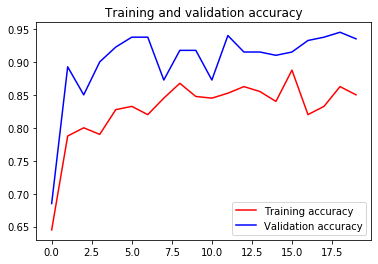

In [12]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)